In [1]:
import sys
import os
from matplotlib import pyplot as plt

sys.path.append("..")
os.chdir("/home/sean/HAI/main_server/hai")
import hai

Input password for image encryption.
········


In [20]:
import database as db

In [206]:
import time
current_time = time.time()
print(current_time)

1504945041.2682316


In [207]:
query = {"user_name": "sean", "cam_id": "-1", "summary":{"$exists": True}, "time": {"$gt": current_time}}
n = db.mongo.images.find(query).sort([("time",-1)])
image_data = list(n)

query = {"user_name": "sean", "time": {"$gt": current_time}}
n = db.mongo.hue.find(query).sort([("time",-1)])
hue_data = list(n)

print(len(image_data), len(hue_data))

6514 2804


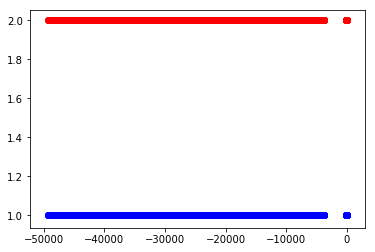

In [208]:
import numpy as np
import time
current_time = time.time()
image_times = [img["time"]-current_time for img in image_data]
hue_times = [d["time"]-current_time for d in hue_data]
plt.scatter(image_times, np.ones(len(image_times)), color="blue")
plt.scatter(hue_times, np.ones(len(hue_times))*2, color="red")
plt.show()

In [209]:
hue_data[0]

{'_id': ObjectId('59b3a3891d41c87937e306ed'),
 'lights': '[{"id": "1", "modelid": "LCT007", "state": {"on": true, "xy": [0, 0], "hue": 0, "reachable": false, "effect": "none", "alert": "none", "colormode": "hs", "sat": 0, "ct": 0, "bri": 0}, "type": "Extended color light", "uniqueid": "00:17:88:01:02:06:bc:4f-0b", "name": "Hue color lamp 1", "swversion": "", "manufacturername": "Philips"}, {"id": "2", "modelid": "LCT007", "state": {"on": false, "xy": [0.4449, 0.4066], "hue": 15327, "reachable": true, "effect": "none", "alert": "none", "colormode": "ct", "sat": 121, "ct": 346, "bri": 112}, "type": "Extended color light", "uniqueid": "00:17:88:01:02:04:d6:7c-0b", "name": "Hue color lamp 2", "swversion": "5.38.1.14919", "manufacturername": "Philips"}, {"id": "3", "modelid": "LCT007", "state": {"on": false, "xy": [0.4449, 0.4066], "hue": 15324, "reachable": true, "effect": "none", "alert": "none", "colormode": "ct", "sat": 121, "ct": 346, "bri": 254}, "type": "Extended color light", "uniqu

In [210]:
def get_objects(data):
    look_all, touch_all = [], []
    for n in data:
        look_objects = []
        touch_objects = []
        for obj in n["summary"]:
            if obj["label"] == "person" and "touching" in obj:
                touch_objects.extend(obj["touching"])
                look_objects.append(obj["looking"])
        look_all.extend(look_objects)
        touch_all.extend(touch_objects)
    return touch_all, look_all

touch_list, look_list = get_objects(image_data)
touch_classes = list(set(touch_list))
look_classes = list(set(look_list))
look_classes.remove("None")

In [211]:
print(touch_classes, look_classes)
touch_classes.index("person")

['remote', 'keyboard', 'person', 'laptop', 'dog', 'couch', 'handbag', 'cat', 'bottle', 'book', 'cell phone'] ['remote', 'person', 'laptop', 'keyboard', 'dog', 'couch', 'handbag', 'cat', 'book', 'cell phone']


2

In [212]:
def data2vec(data):
    person_exists = 0
    touch_vec = np.zeros(len(touch_classes))
    look_vec = np.zeros(len(look_classes))
    #brightness = data["brightness"]

    for obj in data["summary"]:
        if obj["label"] == "person":
            person_exists = 1
            
            if "touching" in obj:
                for t_obj in obj["touching"]:
                    touch_vec[touch_classes.index(t_obj)] = 1
                if obj["looking"] and obj["looking"] != "None":
                    look_vec[look_classes.index(obj["looking"])] = 1
        
    return np.concatenate([[person_exists], touch_vec, look_vec])

In [213]:
hue_classes = []
dataX = [] # summaries
dataY = [] # corresponding hue classes?

dataX = [data2vec(data) for data in image_data]

In [214]:
dataX = np.array(dataX)
print(dataX.shape)

(6514, 22)


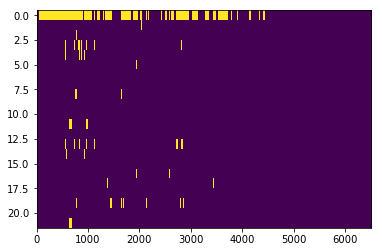

missing file ./pose_data/36d158d2-3fab-4670-b838-7e19f9a2929a_keypoints.json
missing file ./pose_data/abc0bc1f-d1d2-4628-96e5-04ca0996606a_keypoints.json


In [215]:
%matplotlib inline
plt.imshow(dataX.T, aspect="auto")

In [ ]:
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

dataX = preprocessing.scale(dataX)
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(dataX, dataY)
score = clf.score(dataX, dataY)
print("knn:", score)

from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(dataX, dataY)
score = logreg.score(dataX, dataY)
print("logreg:", score)

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(dataX, dataY)
score = clf_gini.score(dataX, dataY)
print("tree:", score)